## Dynamics

Dynamics | $\partial_{\tau}x_i=$ |
| :--------: | :-------: |
Biochemical | $F -B x_i - R \sum_j A_{ij} x_i x_j$ |
Epidemics | $-B x_i + R \sum_j A_{ij} (1-x_i)x_j$ |
Neuronal | $-B x_i + C \tanh x_i + R \sum_j A_{ij} \tanh x_j$ |
Population | $-B x_i^{b} + R \sum_j A_{ij} x_j^a$ |
Synchronization | $\omega_i + R \sum_j A_{ij} \sin(x_j-x_i)$ |

## Test Experiments

In [1]:
from utils.utils import *
import optuna
from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend
from experiments.experiments_gkan import ExperimentsGKAN
from experiments.experiments_mpnn import ExperimentsMPNN
from train_and_eval import eval_model

storage = JournalStorage(JournalFileBackend("optuna_journal_storage.log"))

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Kuramoto MPNN

In [2]:
optuna.delete_study(study_name="model-kuramoto-mpnn-test-new-dataset", storage=storage)

In [6]:
config_path = './configs/config_input_noise/config_kuramoto_input_noise.yml'
config = load_config(config_path)
config['epochs'] = 10
#config["device"] = "cuda"
#config["data_folder"] = "./data_noise"
#config["noise_scale"] = 0.01 

exp = ExperimentsGKAN(
    config=config,
    n_trials=1,
    study_name='test-new-dataset',
    process_id=0,
)

Processing...


Building the dataset...


Done!


In [7]:
exp.run()

[I 2025-05-11 16:36:08,439] Using an existing study with name 'model-kuramoto-gkan-test-new-dataset' instead of creating a new one.
[I 2025-05-11 16:40:05,346] Trial 1 finished with value: 0.07084023207426071 and parameters: {'lr': 0.001067115165372254, 'lamb': 1.0, 'batch_size': 32, 'use_orig_reg': True, 'lamb_g_net': 0.0006923135295081628, 'lamb_h_net': 0.0044870655715361024, 'grid_size_g_net': 7, 'spline_order_g_net': 2, 'range_limit_g_net': 7, 'mu_1_g_net': 0.5, 'mu_2_g_net': 0.5, 'hidden_dim_g_net': 3, 'grid_size_h_net': 6, 'spline_order_h_net': 2, 'range_limit_h_net': 5, 'mu_1_h_net': 0.6, 'mu_2_h_net': 0.8, 'hidden_dim_h_net': 3}. Best is trial 1 with value: 0.07084023207426071.


### Lower bound

In [3]:
import torch
from models.utils.MPNN import MPNN
from models.baseline.MPNN_ODE import MPNN_ODE

In [8]:
g_symb = lambda x: torch.sin(x[:, 1] - x[:, 0]).unsqueeze(-1)
h_symb = lambda x: 2.0 + 0.5*x[:, 1].unsqueeze(-1)

symb = MPNN(
    g_net = g_symb,
    h_net = h_symb, 
    message_passing=True,
    include_time=False
)

symb_ode = MPNN_ODE(
    conv=symb,
    model_path="./saved_models_optuna/symb_kuramoto",
    adjoint=True,
    integration_method="dopri5"
)

In [9]:
from train_and_eval import eval_model

symb_valid_loss = eval_model(
    model=symb_ode,
    valid_data=exp.valid_set,
    criterion=torch.nn.L1Loss(),
    scaler=exp.scaler,
    inverse_scale=False
)

In [10]:
print(symb_valid_loss)

0.04710772633552551


### Epidemics MPNN

In [10]:
optuna.delete_study(study_name="model-epidemics-mpnn-test-epidemics", storage=storage)

In [4]:
config_path = './configs/config_epidemics_mpnn.yml'
config = load_config(config_path)
config['epochs'] = 10

exp = ExperimentsMPNN(
    config=config,
    n_trials=1,
    study_name='test-epidemics',
    process_id=0,
)

Building the dataset...


Processing...
Done!


In [12]:
exp.run()

[I 2025-05-10 10:12:29,327] A new study created in Journal with name: model-epidemics-mpnn-test-epidemics


Epoch: 0 	 Training loss: 0.01012 	 Val Loss: 0.00678 	 Tot Loss: 0.01012
Epoch: 1 	 Training loss: 0.00808 	 Val Loss: 0.00544 	 Tot Loss: 0.00808
Epoch: 2 	 Training loss: 0.00775 	 Val Loss: 0.00617 	 Tot Loss: 0.00775
Epoch: 3 	 Training loss: 0.00734 	 Val Loss: 0.00518 	 Tot Loss: 0.00734
Epoch: 4 	 Training loss: 0.00672 	 Val Loss: 0.00581 	 Tot Loss: 0.00672
Epoch: 5 	 Training loss: 0.00607 	 Val Loss: 0.00549 	 Tot Loss: 0.00607
Epoch: 6 	 Training loss: 0.00591 	 Val Loss: 0.00457 	 Tot Loss: 0.00591
Epoch: 7 	 Training loss: 0.00581 	 Val Loss: 0.00477 	 Tot Loss: 0.00581
Epoch: 8 	 Training loss: 0.00552 	 Val Loss: 0.00428 	 Tot Loss: 0.00552
Epoch: 9 	 Training loss: 0.00528 	 Val Loss: 0.00412 	 Tot Loss: 0.00528

Loading best model found at epoch 9 with val loss 0.004118029959499836
Test loss: 0.0026830669958144426


[I 2025-05-10 10:13:10,063] Trial 0 finished with value: 0.004118029959499836 and parameters: {'lr': 0.0007775093404832605, 'lamb': 0.0, 'batch_size': 16, 'n_hidden_layers_g_net': 2, 'hidden_dims_g_net': 56, 'af_g_net': 'softplus', 'drop_p_g_net': 0.00157630723324707, 'n_hidden_layers_h_net': 2, 'hidden_dims_h_net': 24, 'af_h_net': 'relu', 'drop_p_h_net': 0.00020863994358772403}. Best is trial 0 with value: 0.004118029959499836.


In [13]:
model_path_mpnn = './saved_models_optuna/model-epidemics-mpnn/test-epidemics/0/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=150
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=9000,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [14]:
mpnn_symb

\sum_{j}( 0.116708815*exp(-x_i*exp(x_j))) - 0.15959646*tanh(log(x_i))

### Neuronal MPNN

In [11]:
optuna.delete_study(study_name="model-neuronal-mpnn-test-neuronal", storage=storage)

In [3]:
config_path = './configs/config_noise/config_neuronal_noise.yml'
config = load_config(config_path)
config['epochs'] = 10

exp = ExperimentsMPNN(
    config=config,
    n_trials=1,
    study_name='test-neuronal',
    process_id=0,
)

In [13]:
exp.run()

[I 2025-05-09 17:07:45,709] A new study created in Journal with name: model-neuronal-mpnn-test-neuronal


Epoch: 0 	 Training loss: 0.15600 	 Val Loss: 0.09005 	 Tot Loss: 0.15600
Epoch: 1 	 Training loss: 0.05407 	 Val Loss: 0.07933 	 Tot Loss: 0.05407
Epoch: 2 	 Training loss: 0.05492 	 Val Loss: 0.00986 	 Tot Loss: 0.05492
Epoch: 3 	 Training loss: 0.02307 	 Val Loss: 0.02946 	 Tot Loss: 0.02307
Epoch: 4 	 Training loss: 0.02772 	 Val Loss: 0.00445 	 Tot Loss: 0.02772
Epoch: 5 	 Training loss: 0.01449 	 Val Loss: 0.02453 	 Tot Loss: 0.01449
Epoch: 6 	 Training loss: 0.01730 	 Val Loss: 0.01004 	 Tot Loss: 0.01730
Epoch: 7 	 Training loss: 0.00799 	 Val Loss: 0.00930 	 Tot Loss: 0.00799
Epoch: 8 	 Training loss: 0.01102 	 Val Loss: 0.00358 	 Tot Loss: 0.01102
Epoch: 9 	 Training loss: 0.00579 	 Val Loss: 0.01125 	 Tot Loss: 0.00579

Loading best model found at epoch 8 with val loss 0.003580222139135003
Test loss: 0.004640685394406319


[I 2025-05-09 17:08:23,447] Trial 0 finished with value: 0.003580222139135003 and parameters: {'lr': 0.022198182869050127, 'lamb': 0.0, 'batch_size': 32, 'n_hidden_layers_g_net': 2, 'hidden_dims_g_net': 32, 'af_g_net': 'softplus', 'drop_p_g_net': 0.0005185973727913854, 'n_hidden_layers_h_net': 1, 'hidden_dims_h_net': 40, 'af_h_net': 'tanh', 'drop_p_h_net': 0.018136511652483187}. Best is trial 0 with value: 0.003580222139135003.


In [5]:
model_path_mpnn = './saved_models_optuna/model-neuronal-mpnn/test-neuronal/0/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=150
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=9000,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [6]:
mpnn_symb


\sum_{j}( log(log(tanh(x_j/x_i) + 1) + 1)) + 0.14861982/tanh(exp(x_i))

In [18]:
config_path = './configs/config_neuronal.yml'
config = load_config(config_path)
config['epochs'] = 5

exp = ExperimentsGKAN(
    config=config,
    n_trials=1,
    study_name='test-neuronal',
    process_id=0,
)

In [19]:
exp.run()

[I 2025-05-09 14:21:16,405] Using an existing study with name 'model-neuronal-gkan-test-neuronal' instead of creating a new one.


Epoch: 0 	 Training loss: 0.00051 	 Val Loss: 0.00028 	 Tot Loss: 0.00543
Epoch: 1 	 Training loss: 0.00028 	 Val Loss: 0.00014 	 Tot Loss: 0.00507
Epoch: 2 	 Training loss: 0.00016 	 Val Loss: 0.00007 	 Tot Loss: 0.00483
Epoch: 3 	 Training loss: 0.00012 	 Val Loss: 0.00005 	 Tot Loss: 0.00453
Epoch: 4 	 Training loss: 0.00011 	 Val Loss: 0.00004 	 Tot Loss: 0.00443

Loading best model found at epoch 4 with val loss 4.3011452362407e-05
Test loss: 0.000152996537508443


[I 2025-05-09 14:24:39,155] Trial 1 finished with value: 4.3011452362407e-05 and parameters: {'lr': 0.014578887605134958, 'lamb': 1.0, 'batch_size': 32, 'use_orig_reg': True, 'lamb_g_net': 9.722521843140844e-05, 'lamb_h_net': 0.0017345619188380956, 'grid_size_g_net': 9, 'spline_order_g_net': 3, 'range_limit_g_net': 1, 'mu_1_g_net': 0.6, 'mu_2_g_net': 1.0, 'hidden_dim_g_net': 1, 'grid_size_h_net': 7, 'spline_order_h_net': 2, 'range_limit_h_net': 3, 'mu_1_h_net': 1.0, 'mu_2_h_net': 0.7, 'hidden_dim_h_net': 2}. Best is trial 1 with value: 4.3011452362407e-05.


### Biochemical MPNN

In [14]:
optuna.delete_study(study_name="model-biochemical-mpnn-test-biochemical", storage=storage)

In [6]:
config_path = './configs/config_biochemical_mpnn.yml'
config = load_config(config_path)
config['epochs'] = 10

exp = ExperimentsMPNN(
    config=config,
    n_trials=1,
    study_name='test-biochemical',
    process_id=0,
)

Processing...


Building the dataset...


Done!


In [16]:
exp.run()

[I 2025-05-09 17:08:40,883] A new study created in Journal with name: model-biochemical-mpnn-test-biochemical


Epoch: 0 	 Training loss: 0.01061 	 Val Loss: 0.00656 	 Tot Loss: 0.01061
Epoch: 1 	 Training loss: 0.00874 	 Val Loss: 0.00552 	 Tot Loss: 0.00874
Epoch: 2 	 Training loss: 0.00779 	 Val Loss: 0.00526 	 Tot Loss: 0.00779
Epoch: 3 	 Training loss: 0.00718 	 Val Loss: 0.00465 	 Tot Loss: 0.00718
Epoch: 4 	 Training loss: 0.00654 	 Val Loss: 0.00416 	 Tot Loss: 0.00654
Epoch: 5 	 Training loss: 0.00580 	 Val Loss: 0.00388 	 Tot Loss: 0.00580
Epoch: 6 	 Training loss: 0.00511 	 Val Loss: 0.00322 	 Tot Loss: 0.00511
Epoch: 7 	 Training loss: 0.00457 	 Val Loss: 0.00279 	 Tot Loss: 0.00457
Epoch: 8 	 Training loss: 0.00387 	 Val Loss: 0.00227 	 Tot Loss: 0.00387
Epoch: 9 	 Training loss: 0.00335 	 Val Loss: 0.00189 	 Tot Loss: 0.00335

Loading best model found at epoch 9 with val loss 0.001890188199467957
Test loss: 0.0018362425034865737


[I 2025-05-09 17:09:18,946] Trial 0 finished with value: 0.001890188199467957 and parameters: {'lr': 0.0011331826087084096, 'lamb': 0.0, 'batch_size': 16, 'n_hidden_layers_g_net': 2, 'hidden_dims_g_net': 24, 'af_g_net': 'tanh', 'drop_p_g_net': 0.012105133221616455, 'n_hidden_layers_h_net': 1, 'hidden_dims_h_net': 16, 'af_h_net': 'softplus', 'drop_p_h_net': 0.01289533029330185}. Best is trial 0 with value: 0.001890188199467957.


In [11]:
model_path_mpnn = './saved_models_optuna/model-biochemical-mpnn/test-biochemical/0/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=9000,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [12]:
mpnn_symb

\sum_{j}( -0.15344319*x_i*exp(x_j)) - 0.14971581*x_i + 0.87793374

In [23]:
config_path = './configs/config_biochemical.yml'
config = load_config(config_path)
config['epochs'] = 5

exp = ExperimentsGKAN(
    config=config,
    n_trials=1,
    study_name='test-biochemical',
    process_id=0,
)

In [24]:
exp.run()

[I 2025-05-09 14:43:07,097] A new study created in Journal with name: model-biochemical-gkan-test-biochemical


Epoch: 0 	 Training loss: 0.00011 	 Val Loss: 0.00007 	 Tot Loss: 0.00409
Epoch: 1 	 Training loss: 0.00010 	 Val Loss: 0.00006 	 Tot Loss: 0.00416
Epoch: 2 	 Training loss: 0.00010 	 Val Loss: 0.00005 	 Tot Loss: 0.00426
Epoch: 3 	 Training loss: 0.00009 	 Val Loss: 0.00005 	 Tot Loss: 0.00439
Epoch: 4 	 Training loss: 0.00009 	 Val Loss: 0.00004 	 Tot Loss: 0.00456

Loading best model found at epoch 4 with val loss 4.181330223218538e-05
Test loss: 2.1962674509268254e-05


[I 2025-05-09 14:45:45,104] Trial 0 finished with value: 4.181330223218538e-05 and parameters: {'lr': 0.0029212460068246317, 'lamb': 1.0, 'batch_size': 16, 'use_orig_reg': True, 'lamb_g_net': 0.0012543290658560168, 'lamb_h_net': 1.2825379943612229e-06, 'grid_size_g_net': 8, 'spline_order_g_net': 1, 'range_limit_g_net': 1, 'mu_1_g_net': 0.7, 'mu_2_g_net': 0.9, 'hidden_dim_g_net': 3, 'grid_size_h_net': 6, 'spline_order_h_net': 2, 'range_limit_h_net': 3, 'mu_1_h_net': 0.6, 'mu_2_h_net': 0.5, 'hidden_dim_h_net': 3}. Best is trial 0 with value: 4.181330223218538e-05.


### Population MPNN

In [ ]:
config_path = './configs/config_population_mpnn.yml'
config = load_config(config_path)
config['epochs'] = 10

exp = ExperimentsMPNN(
    config=config,
    n_trials=1,
    study_name='test-population',
    process_id=0,
)

Processing...


Building the dataset...


Done!


In [6]:
exp.training_set.raw_data_sampled.mean().item()

0.7820039391517639

In [7]:
exp.run()

[I 2025-05-13 11:23:33,704] Using an existing study with name 'model-population-mpnn-test-biochemical' instead of creating a new one.


Epoch: 0 	 Training loss: 0.03171 	 Val Loss: 0.01530 	 Tot Loss: 0.03171
Epoch: 1 	 Training loss: 0.03068 	 Val Loss: 0.01343 	 Tot Loss: 0.03068
Epoch: 2 	 Training loss: 0.02000 	 Val Loss: 0.02636 	 Tot Loss: 0.02000
Epoch: 3 	 Training loss: 0.02125 	 Val Loss: 0.00707 	 Tot Loss: 0.02125
Epoch: 4 	 Training loss: 0.01692 	 Val Loss: 0.01132 	 Tot Loss: 0.01692
Epoch: 5 	 Training loss: 0.01374 	 Val Loss: 0.01354 	 Tot Loss: 0.01374
Epoch: 6 	 Training loss: 0.01627 	 Val Loss: 0.01240 	 Tot Loss: 0.01627
Epoch: 7 	 Training loss: 0.00921 	 Val Loss: 0.00912 	 Tot Loss: 0.00921
Epoch: 8 	 Training loss: 0.01339 	 Val Loss: 0.00363 	 Tot Loss: 0.01339


[I 2025-05-13 11:23:55,186] Trial 3 finished with value: 0.0036307384725660086 and parameters: {'lr': 0.043711667089650526, 'lamb': 0.0, 'batch_size': 32, 'n_hidden_layers_g_net': 1, 'hidden_dims_g_net': 16, 'af_g_net': 'relu', 'drop_p_g_net': 0.023116492605130188, 'n_hidden_layers_h_net': 1, 'hidden_dims_h_net': 64, 'af_h_net': 'tanh', 'drop_p_h_net': 0.0010948652973245935}. Best is trial 0 with value: 0.0016587207792326808.


Epoch: 9 	 Training loss: 0.00814 	 Val Loss: 0.01200 	 Tot Loss: 0.00814

Loading best model found at epoch 8 with val loss 0.0036307384725660086
Test loss: 0.007985778152942657


## Symbolic reg

### Utils

In [2]:
from models.utils.MPNN import MPNN
from models.baseline.MPNN_ODE import MPNN_ODE
from train_and_eval import eval_model
from datasets.SyntheticData import SyntheticData
from sympy import symbols, sin, summation, simplify

In [3]:
def get_model(g, h, message_passing=True, include_time=False, atol=1e-5, rtol=1e-3):
    conv = MPNN(
        g_net = g,
        h_net = h, 
        message_passing=message_passing,
        include_time=include_time
    )
    
    symb = MPNN_ODE(
        conv=conv,
        model_path="./saved_models_optuna/tmp_symb",
        adjoint=True,
        integration_method="dopri5",
        atol=atol,
        rtol=rtol
    )
    
    return symb


def get_symb_test_error(g_symb, h_symb, test_set, message_passing=False, include_time=False, atol=1e-5, rtol=1e-3, scaler = None, inverse_scale=False):
    
    # total_len = len(dataset)
    # test_set = dataset[int(0.9*total_len):]
    
    symb = get_model(
        g=g_symb,
        h=h_symb,
        message_passing=message_passing,
        include_time=include_time,
        atol=atol,
        rtol=rtol
    )
    
    test_loss = eval_model(
        model=symb,
        valid_data=test_set,
        criterion=torch.nn.L1Loss(),
        scaler=scaler,
        inverse_scale=inverse_scale
    )
    
    return test_loss
    

### LB losses


In [ ]:
KUR = SyntheticData(
    root = './data',
    dynamics='Kuramoto',
    horizon=15
)
tot_len = len(KUR)
KUR = KUR[int(0.9*tot_len):]

g_symb = lambda x: torch.sin(x[:, 1] - x[:, 0]).unsqueeze(-1)
h_symb = lambda x: 2.0 + 0.5 * x[:, 1].unsqueeze(-1)

test_loss = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=KUR,
    message_passing=True,
    include_time=False,
    atol=1e-5,
    rtol=1e-3
)

print(f"Kuramoto: {test_loss}")




Kuramoto: 1.5289064094758942e-06


### Kuramoto GKAN noise

#### Black-box fitting

In [5]:
model_path_gkan = './saved_models_optuna/model-kuramoto-gkan/kuramoto-gkan_noise_1/0/gkan'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=9000,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [6]:
gkan_symb

\sum_{j}( -0.49638912*sin(x_i - x_j)) - 0.0006680012*x_i**3 + 2.0642977

#### Symb formula test error

In [71]:
g_symb = lambda x: torch.sin(x[:, 0] - x[:, 1]).unsqueeze(-1)
h_symb = lambda x: 2.0642977 - 0.49638912 * x[:, 1].unsqueeze(-1) - 0.0006680012 * (x[:, 0]**3).unsqueeze(-1)

dataset = SyntheticData(
    root = './data',
    dynamics='Kuramoto',
    horizon=15
)

print(get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    dataset=dataset,
    message_passing=True,
    include_time=False
))

0.0020491345785558224


#### Spline-wise fitting

In [15]:
model_path_gkan = './saved_models_optuna/model-kuramoto-gkan/kuramoto-gkan_noise_1/0/gkan'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

spline_wise_gkan = fit_model(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=9000,
    message_passing=False,
    theta=0.1
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [16]:
spline_wise_gkan

\sum_{j}( 0.5982343 - sin(log(0.98709450879169*(0.771155932158011*x_i - 0.739762198544719*x_j + 1)**2 + 1))) + log(7.5371747 - 0.0010331396*exp(x_i))

### Kuramoto GKAN

#### Black-box fitting

In [22]:
model_path_gkan = './saved_models_optuna/model-kuramoto-gkan/kuramoto-gkan_3/0/gkan'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=9999,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [23]:
gkan_symb

\sum_{j}( -0.50056*sin(x_i - x_j)) + 2.0027082 - 0.013696434*exp(-x_i)

In [5]:
g_symb = lambda x: torch.sin(x[:, 0] - x[:, 1]).unsqueeze(-1)
h_symb = lambda x: 2.0027082 - 0.50056 * x[:, 1].unsqueeze(-1) - 0.013696434 * (torch.exp(-x[:, 0])).unsqueeze(-1)

dataset = SyntheticData(
    root = './data',
    dynamics='Kuramoto',
    horizon=15
)

print(get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    dataset=dataset,
    message_passing=True,
    include_time=False
))

6.243983807507902e-05


#### Spline-wise fitting

In [26]:
model_path_gkan = './saved_models_optuna/model-kuramoto-gkan/kuramoto-gkan_3/0/gkan'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

spline_wise_gkan = fit_model(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=9000,
    message_passing=False,
    theta=0.01
)

Pruning node (0,0)


/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Pruning node (0,0)


In [27]:
spline_wise_gkan

\sum_{j}( -0.49421662*sin(Abs(0.6986717*x_i - 0.71818024*x_j + 1.1343801) - 0.8900419))

In [ ]:
x, e, t = sample_from_spatio_temporal_graph(
    dataset=exp.training_set.raw_data_sampled[0],
    edge_index=exp.training_set[0].edge_index,
    t = exp.training_set.t_sampled[0],
    sample_size=-1
)

### Kuramoto Input noise

#### Black-box fitting

In [6]:
model_path_gkan = './saved_models_optuna/model-kuramoto-gkan/kuramoto-gkan_in_noise_/2/gkan'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=9000,
    theta=-np.inf,
    message_passing=False,
    include_time=True
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [7]:
gkan_symb

\sum_{j}( -0.50021183*sin(x_i - x_j)) - 5.527247e-10*exp(2*x_i) + 2.0041

In [8]:
g_symb = lambda x: torch.sin(x[:, 0] - x[:, 1]).unsqueeze(-1)
h_symb = lambda x: 2.0041 - 0.50021183 * x[:, 1].unsqueeze(-1) - (5.527247 * 10e-10 * torch.exp(2*x[:, 0])).unsqueeze(-1)

dataset = SyntheticData(
    root = './data_input_noise/',
    dynamics='Kuramoto',
    horizon=15
)

print(get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    dataset=dataset,
    message_passing=True,
    include_time=False
))

0.0003422814479563385


#### Spline-wise

In [9]:
model_path_gkan = './saved_models_optuna/model-kuramoto-gkan/kuramoto-gkan_in_noise_/2/gkan'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

spline_wise_gkan = fit_model(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=9000,
    message_passing=False,
    theta=0.1,
    include_time=True
)

Pruning node (0,1)


/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib

Pruning node (0,0)
Pruning node (0,1)


In [10]:
spline_wise_gkan

\sum_{j}( 0.3760461*sin(-0.43199617*x_i + 0.43399328*x_j + 0.5978921)**2 - tanh(sin(0.449025583052984*x_i - 0.4269054*x_j + 0.7687427))**2 + 0.16077052034278)

### Epidemics GKAN noise

#### Black-box fitting

In [8]:
model_path_gkan = './saved_models_optuna/model-epidemics-gkan/epidemics_gkan_noise/0/gkan'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=9999,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [9]:
gkan_symb

\sum_{j}( x_j*(0.49554533 - 0.4909881*x_i)) + log(1 - 0.42728114*x_i)

In [6]:
g_symb = lambda x: x[:, 1].unsqueeze(-1) * (0.49554533 - 0.4909881 * x[:, 0].unsqueeze(-1))
h_symb = lambda x: x[:, 1].unsqueeze(1) + torch.log(1 - 0.42728114 * x[:, 0]).unsqueeze(-1)

dataset = SyntheticData(
    root = './data',
    dynamics='Epidemics',
    horizon=15
)

print(get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    dataset=dataset,
    message_passing=True,
    include_time=False
))

0.0001492895680712536


#### Spline-wise fitting

In [4]:
model_path_gkan = './saved_models_optuna/model-epidemics-gkan/epidemics_gkan_noise/0/gkan'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

spline_wise_gkan = fit_model(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=9000,
    message_passing=False,
    theta=0.01
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib

In [5]:
spline_wise_gkan

\sum_{j}( 0.0777536229570903*x_j + 0.194034710725233*(-x_i + 0.689400647019368*x_j + 0.773931407317459)**2 - 0.05327123*tanh(2.71368078831776*x_i**2 + 1.82029175433439*x_j - 3.19666957728419) - 0.0171054934048614 - 0.018127087267707/sin(tan(x_i) + 0.51147836)) - 0.20410627*exp(x_i**3) - 0.26780808*tanh(1.55785797270583*x_i + 0.133755208542346) + 0.180408001255975

### Epidemics GKAN

#### Black-box fitting

In [6]:
model_path_gkan = './saved_models_optuna/model-epidemics-gkan/epidemics_gkan_/0/gkan'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=9999,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [7]:
gkan_symb

\sum_{j}( 0.5001196*x_j*(0.9996479 - x_i)) - 0.49795532*x_i

In [7]:
g_symb = lambda x: 0.5001196*x[:, 1].unsqueeze(-1) * (0.9996479 - x[:, 0].unsqueeze(-1))
h_symb = lambda x: x[:, 1].unsqueeze(1) - 0.49795532 * x[:, 0].unsqueeze(-1)

dataset = SyntheticData(
    root = './data',
    dynamics='Epidemics',
    horizon=15
)

print(get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    dataset=dataset,
    message_passing=True,
    include_time=False
))

2.2776461264584213e-05


#### Spline-wise fitting

In [ ]:
# TODO

### Neuronal GKAN noise

In [2]:
model_path_gkan = './saved_models_optuna/model-neuronal-gkan/neuronal_gkan_noise/0/gkan'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=9000,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [3]:
gkan_symb

\sum_{j}( 0.2994311*tanh(x_j)) - 0.22234954*x_i + 0.2725751

### Neuronal GKAN

In [10]:
model_path_gkan = './saved_models_optuna/model-neuronal-gkan/neuronal_gkan_/1/gkan'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=9999,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [11]:
gkan_symb

\sum_{j}( 0.29298076*tanh(x_j)) - 0.18231857*x_i + 0.238917109306232

### Biochemical GKAN Noise

In [8]:
model_path_gkan = './saved_models_optuna/model-biochemical-gkan/biochemical_gkan_noise/0/gkan'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=9999,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [9]:
gkan_symb

\sum_{j}( -0.50734943*x_i*x_j) + exp(-0.5952519*x_i)

### Biochemical GKAN

In [4]:
model_path_gkan = './saved_models_optuna/model-biochemical-gkan/biochemical_gkan_2/2/gkan'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=250
)

gkan_symb = fit_black_box_from_kan(
    n_g_hidden_layers=2,
    n_h_hidden_layers=2,
    device='cuda',
    model_path=model_path_gkan,
    pysr_model=pysr_model,
    sample_size=9999,
    theta=-np.inf,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [5]:
gkan_symb

\sum_{j}( -0.4994442*x_i*x_j) + log(2.6236862 - x_i)

## Real Epid Dataset

### Test

In [2]:
optuna.delete_study(study_name="model-real-epidemics-mpnn-test-epidemics-real", storage=storage)

In [2]:
config_path = './configs/config_real_epidemics_mpnn.yml'
config = load_config(config_path)
config['epochs'] = 10

exp = ExperimentsMPNN(
    config=config,
    n_trials=1,
    study_name='test-epidemics-real',
    process_id=0,
)

In [ ]:
exp.run()

In [9]:
model_path_mpnn = './saved_models_optuna/model-real-epidemics-mpnn/test-epidemics-real/0/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=150
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=9000,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [10]:
mpnn_symb

\sum_{j}( exp(tanh(x_i))) + 0.23144726*x_i + 0.25053707

### LB-Baseline

In [6]:
from models.baseline.baseline import LB_ODE

baseline = LB_ODE(
    model_path="./saved_models_optuna/tmp_baseline"
)

scaler = exp.pre_processing(exp.training_set)

eval_model(
    model=baseline,
    valid_data=exp.test_set,
    criterion=torch.nn.L1Loss(),
    scaler=scaler,
    inverse_scale=True
)

458.680419921875

### Baseline 2

In [14]:
from tsl.data.preprocessing.scalers import MinMaxScaler, StandardScaler

def pre_processing(training_set, out_range = (-1, 1), device='cuda', min_max = True):
    all_train_x = torch.cat([data.x.view(-1) for data in training_set], dim=0)  
    if min_max:
        scaler = MinMaxScaler(out_range=out_range)
    else:
        scaler = StandardScaler()
    scaler.fit(all_train_x.detach().cpu())

    scaler.scale = scaler.scale.to(torch.device(device))
    scaler.bias = scaler.bias.to(torch.device(device))

    return scaler

In [15]:
from datasets.RealEpidemics import RealEpidemics

g_symb_base = lambda x: torch.nn.Sigmoid()(x[:, 1] - x[:, 0])
h_symb_base = lambda x:  ( 0.074 * x[:, 0] + 7.130 * x[:, 1]).unsqueeze(-1)

config = load_config("./configs/config_real_epidemics_mpnn.yml")

exp = ExperimentsMPNN(
    config=config,
    n_trials=1,
    study_name='test-baseline',
    process_id=0,
)

# scaler_base = pre_processing(exp.training_set, min_max=False)

print(get_symb_test_error(
    g_symb=g_symb_base,
    h_symb=h_symb_base,
    test_set=exp.test_set,
    message_passing=True,
    include_time=False,
    scaler=None,
    inverse_scale=False
))

448.5691223144531


#### Plots

In [16]:
import matplotlib.pyplot as plt
import json

In [17]:
def plot_predictions(snapshot, t_end, ode_model, y_true, node_idx = 0, scaler=None):
    ode_model.eval()
    T = y_true.shape[0] + 1
    t_start = snapshot.t_span[0]
    eval_time = torch.linspace(t_start.item(), t_end.item(), T, device=t_start.device)
    snapshot.t_span = eval_time
    
    if scaler is not None:
        snapshot.x = scaler.transform(snapshot.x)
    
    y_pred = ode_model(snapshot) # (eval_time-1, N, 1)
    
    if scaler is not None:
        y_pred = scaler.inverse_transform(y_pred)  
    
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    
    T = y_true.shape[0]
    time = time = np.arange(T)
    
    plt.figure(figsize=(10, 5))
    plt.plot(time, y_true[:, node_idx, :], label='y_true', linestyle='-', marker='o')
    plt.plot(time, y_pred[:, node_idx, :], label='y_pred', linestyle='--', marker='x')
    plt.title(f"Comparison for N_idx = {node_idx}")
    plt.xlabel("Time Step (T)")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    
    

In [18]:
start_x = exp.training_set[0]
t_end = exp.test_set[-1].t_span[-1]
y_true = exp.training_set.raw_data_sampled
with open("./data/Real-Epidemics/countries_dict.json", 'r') as f:
    countries_df = json.load(f)

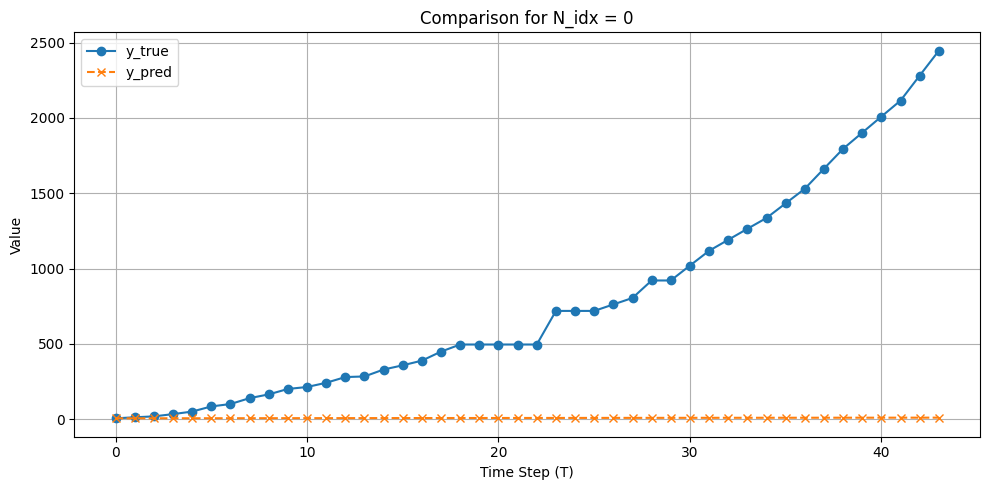

In [19]:
base_expr = get_model(
    g=g_symb_base,
    h=h_symb_base,
)


plot_predictions(
    snapshot=start_x,
    t_end = t_end,
    ode_model=base_expr,
    y_true=y_true[0, 1:, :, :],
    node_idx=countries_df["Canada"],
    scaler=None
)